<a href="https://colab.research.google.com/github/rubenguerra/hello_world/blob/master/clasificadorImagenes2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clasificador de imágenes con Pytorch

In [0]:
# Se importan las bibliotecas

import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
## Como la salida de los datos son imágenes en el rango [0,1], hay que transformarlos y normalizarlos a un rango de[-1,1]

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader= torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform= transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes= ('Avión', 'auto', 'pajaro', 'gato',
          'venado', 'perro', 'rana', 'caballo', 'barco', 'camioneta')

Files already downloaded and verified
Files already downloaded and verified


Vamos a mostrar algunas imágenes

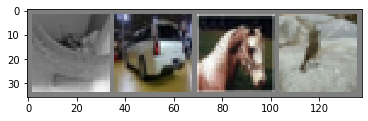

 gato  auto caballo pajaro


In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Función que permite mostra las imágenes

def imshow(img):
  img = img / 2 + 0.5 # NO normalizada
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()


# Se toman algunas imágenes al azar
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Muestra las imágenes
imshow(torchvision.utils.make_grid(images))

# Imprime las etiquetas
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

SE CONSTRUYE LA RED NEURONAL CONVOLUCIONAL

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x


net = Net()

Se crea la función de pérdida y el óptimizador

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

ENTRENANDO LA RED NEURONAL

In [0]:
for epoch in range(2): #ciclo sobre el dataset multiples veces

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    #Coge las entradas, los datos son una lista de [entradas, etiquetas]
    inputs, labels = data

    # gradientes de parámetro cero
    optimizer.zero_grad()

    # continuar + retornar más optimizar
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Imprime los estadísticos
    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

print('Entrenamiento finalizado')


[1,  2000] loss: 2.266
[1,  4000] loss: 1.906
[1,  6000] loss: 1.692
[1,  8000] loss: 1.609
[1, 10000] loss: 1.514
[1, 12000] loss: 1.472
[2,  2000] loss: 1.407
[2,  4000] loss: 1.375
[2,  6000] loss: 1.339
[2,  8000] loss: 1.313
[2, 10000] loss: 1.300
[2, 12000] loss: 1.283
Entrenamiento finalizado


AHORA GUARDAMOS NUESTRO MODELO ENTRENADO

In [0]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(),PATH)

PROBANDO LA RED CON LOS DATOS DE PRUEBA

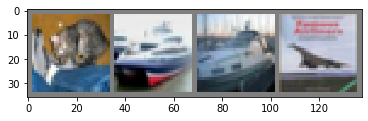

Aciertos:   gato barco barco Avión


In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

#Imprime las imágenes
imshow(torchvision.utils.make_grid(images))
print('Aciertos: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

CARGAMOS EL MODELO SALVADO ANTERIORMENTE

In [0]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [0]:
outputs = net(images)

In [0]:
_, predicted = torch.max(outputs, 1)

print('Predichos: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predichos:   gato barco  auto Avión


In [0]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Certeza de la red neuronal en las 10000 imágenes de prueba: %d %%' % (
    100*correct/total
))

Certeza de la red neuronal en las 10000 imágenes de prueba: 54 %


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1


for i in range(10):
  print('Certeza de %5s : %2d %%' % (
      classes[i], 100 * class_correct[i] / class_total[i]
  ))

Certeza de Avión : 61 %
Certeza de  auto : 56 %
Certeza de pajaro : 21 %
Certeza de  gato : 39 %
Certeza de venado : 34 %
Certeza de perro : 53 %
Certeza de  rana : 74 %
Certeza de caballo : 59 %
Certeza de barco : 68 %
Certeza de camioneta : 72 %
